# Import libraries, load data, create graph

In [5]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

import matplotlib.pyplot as plt

import stellargraph as sg
from stellargraph.data import EdgeSplitter, UniformRandomWalk, UnsupervisedSampler
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification, MeanAggregator, LinkEmbedding
from stellargraph.calibration import expected_calibration_error, plot_reliability_diagram
from stellargraph.calibration import IsotonicCalibration, TemperatureCalibration

from tables import open_file, Float16Atom

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import random

from tensorflow import keras
import tensorflow as tf
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

In [8]:
genre_df = pd.read_csv("genres.csv")
graph_df = pd.read_csv("graph.csv")

genre_df.set_index('artist_name', inplace=True)

display(genre_df)
display(graph_df)

,20th_century,20th_century_classical,21st_century_classical,2_step_garage,2_tone,a_cappella,aboriginal_rock,abstract,abstract_hip_hop,acid_folk,...,worship,yoruba,youth_crew,yé_yé,zamba,zef,zeuhl,zouk,zulu,zydeco
artist_name,,,,,,,,,,,,,,,,,,,,,
!!!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""Weird Al"" Yankovic",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'68 Comeback,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'O' Level,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'Til Tuesday,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Škan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Žagar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Žanil Tataj - Žak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,artist_name1,artist_name2
0,!!!,LCD Soundsystem
1,!!!,Maserati (band)
2,!!!,Out Hud
3,!!!,The Juan MacLean
4,!!!,Turing Machine (band)
...,...,...
73034,Žanil Tataj - Žak,Divlje jagode
73035,Željko Bebek,Jutro
73036,Željko Joksimović,Emina Jahović
73037,Željko Joksimović,Haris Džinović


In [14]:
G = sg.StellarGraph(
    nodes=genre_df, edges=graph_df, source_column="artist_name1", target_column="artist_name2"
)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 39244, Edges: 73039

 Node types:
  default: [39244]
    Features: float32 vector, length 1317
    Edge types: default-default->default

 Edge types:
    default-default->default: [73039]
        Weights: all 1 (default)
        Features: none


# Link Prediction

In [10]:
batch_size = 64
epochs = 4  # The number of training epochs for training the GraphSAGE model.
num_samples = [8, 4, 2] # number of layers/iterations in the GraphSAGE model.

# train, test, validation split
train_size = 0.2
test_size = 0.15
val_size = 0.2

In [7]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.15 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=test_size, method="global", keep_connected=True, seed=42
)

** Sampled 10955 positive and 10955 negative edges. **


In [8]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_val = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.2 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=val_size, method="global", keep_connected=True, seed=42
)

** Sampled 12416 positive and 12416 negative edges. **


In [9]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_val)

# Randomly sample a fraction p=0.2 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=train_size, method="global", keep_connected=True, seed=42
)

** Sampled 9933 positive and 9933 negative edges. **


In [10]:
print('=================== TRAIN GRAPH INFO ===================\n\n' + G_train.info() + '\n')
print('\n=================== VALID GRAPH INFO ===================\n\n' + G_val.info() + '\n')
print('\n=================== TEST GRAPH INFO ===================\n\n' + G_test.info() + '\n')

=================== TRAIN GRAPH INFO ===================

StellarGraph: Undirected multigraph
 Nodes: 39244, Edges: 39735

 Node types:
  default: [39244]
    Features: float32 vector, length 1317
    Edge types: default-default->default

 Edge types:
    default-default->default: [39735]
        Weights: all 1 (default)
        Features: none


=================== VALID GRAPH INFO ===================

StellarGraph: Undirected multigraph
 Nodes: 39244, Edges: 49668

 Node types:
  default: [39244]
    Features: float32 vector, length 1317
    Edge types: default-default->default

 Edge types:
    default-default->default: [49668]
        Weights: all 1 (default)
        Features: none


=================== TEST GRAPH INFO ===================

StellarGraph: Undirected multigraph
 Nodes: 39244, Edges: 62084

 Node types:
  default: [39244]
    Features: float32 vector, length 1317
    Edge types: default-default->default

 Edge types:
    default-default->default: [62084]
        Weights

In [13]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
val_gen = GraphSAGELinkGenerator(G_val, batch_size, num_samples)
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)

train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)
val_flow = val_gen.flow(edge_ids_val, edge_labels_val)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

layer_sizes = [32, 32, 32]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.25
)

In [11]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

logits = link_classification(
    output_dim=1, output_act="linear", edge_embedding_method="ip"
)(x_out)

prediction = keras.layers.Activation(keras.activations.sigmoid)(logits)

model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [15]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/graph-sage-epoch{epoch:02d}.h5',
    save_weights_only=False,
    save_best_only=False,
    verbose=1)

history = model.fit(
    train_flow, epochs=epochs, validation_data=val_flow, verbose=1,
    shuffle=True, callbacks=[model_checkpoint_callback]
)

Epoch 1/4
311/311 [==============================] - ETA: 0s - loss: 0.5969 - binary_accuracy: 0.7067
Epoch 00001: saving model to models/graph-sage-epoch01.h5
311/311 [==============================] - 346s 1s/step - loss: 0.5969 - binary_accuracy: 0.7067 - val_loss: 0.5520 - val_binary_accuracy: 0.7488
Epoch 2/4
311/311 [==============================] - ETA: 0s - loss: 0.5577 - binary_accuracy: 0.7556
Epoch 00002: saving model to models/graph-sage-epoch02.h5
311/311 [==============================] - 311s 1s/step - loss: 0.5577 - binary_accuracy: 0.7556 - val_loss: 0.5490 - val_binary_accuracy: 0.7560
Epoch 3/4
311/311 [==============================] - ETA: 0s - loss: 0.5456 - binary_accuracy: 0.7745
Epoch 00003: saving model to models/graph-sage-epoch03.h5
311/311 [==============================] - 287s 923ms/step - loss: 0.5456 - binary_accuracy: 0.7745 - val_loss: 0.5532 - val_binary_accuracy: 0.7487
Epoch 4/4
311/311 [==============================] - ETA: 0s - loss: 0.5359 - b

In [72]:
# Load model after training once
model = tf.keras.models.load_model('models/graph-sage-epoch04.h5', custom_objects={
    'MeanAggregator': MeanAggregator, 'LinkEmbedding': LinkEmbedding})

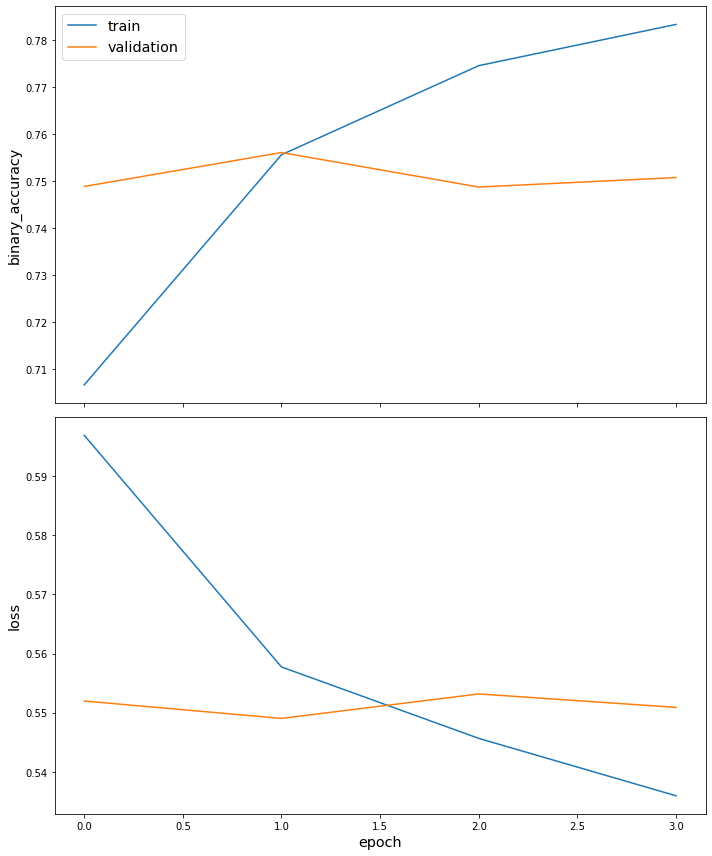

In [16]:
sg.utils.plot_history(history, individual_figsize=(10,6))

In [15]:
train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

343/343 [==============================] - 99s 288ms/step - loss: 0.5470 - binary_accuracy: 0.7558

Train Set Metrics of the trained model:
	loss: 0.5156
	binary_accuracy: 0.8086

Validation Set Metrics of the trained model:
	loss: 0.5509
	binary_accuracy: 0.7519

Test Set Metrics of the trained model:
	loss: 0.5470
	binary_accuracy: 0.7558


In [16]:
num_tests = 1  # the number of times to generate predictions

all_test_predictions = [
    model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
]

343/343 [==============================] - 98s 286ms/step


## Calibration of the model

In [17]:
calibration_data = [
    calibration_curve(
        y_prob=test_predictions, y_true=edge_labels_test, n_bins=10, normalize=True
    )
    for test_predictions in all_test_predictions
]

for fraction_of_positives, mean_predicted_value in calibration_data:
    ece_pre_calibration = expected_calibration_error(
        prediction_probabilities=all_test_predictions[0],
        accuracy=fraction_of_positives,
        confidence=mean_predicted_value,
    )
    print("ECE: (before calibration) {:.4f}".format(ece_pre_calibration))

ECE: (before calibration) 0.3913


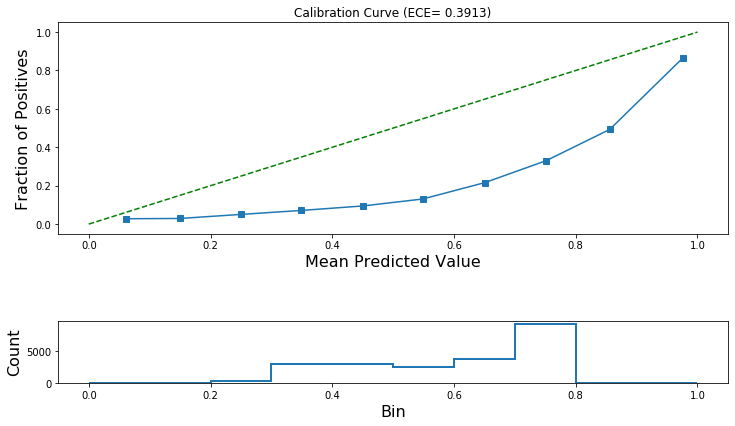

In [18]:
plot_reliability_diagram(
    calibration_data, np.array(all_test_predictions[0]), ece=[ece_pre_calibration]
)

In [19]:
use_platt = False  # True for Platt scaling or False for Isotonic Regression
num_tests = 1
score_model = keras.Model(inputs=x_inp, outputs=logits)

if use_platt:
    all_val_score_predictions = [
        score_model.predict(val_flow, verbose=True) for _ in np.arange(num_tests)
    ]
    all_test_score_predictions = [
        score_model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
    ]
    all_test_probabilistic_predictions = [
        model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
    ]
else:
    all_val_score_predictions = [
        model.predict(val_flow, verbose=True) for _ in np.arange(num_tests)
    ]
    all_test_probabilistic_predictions = [
        model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
    ]

343/343 [==============================] - 98s 287ms/step


In [20]:
val_predictions = np.mean(np.array(all_val_score_predictions), axis=0)
print(val_predictions.shape)

(24832, 1)


In [21]:
# These are the uncalibrated prediction probabilities.
if use_platt:
    test_predictions = np.mean(np.array(all_test_score_predictions), axis=0)
    print("Test predictions shape:" + str(test_predictions.shape))
    lr = TemperatureCalibration()
else:
    test_predictions = np.mean(np.array(all_test_probabilistic_predictions), axis=0)
    print("Test predictions shape:" + str(test_predictions.shape))
    lr = IsotonicCalibration()    

print("Validation predictions shape: " + str(val_predictions.shape))
print("Validation edge labels shape: " + str(edge_labels_val.shape))

Test predictions shape:(21910, 1)
Validation predictions shape: (24832, 1)
Validation edge labels shape: (24832,)


In [22]:
lr.fit(val_predictions, edge_labels_val)
lr_test_predictions = lr.predict(test_predictions)
print("Calibrated test predictions shape: " + str(lr_test_predictions.shape))

Calibrated test predictions shape: (21910, 1)


In [23]:
calibration_data = [
    calibration_curve(
        y_prob=lr_test_predictions, y_true=edge_labels_test, n_bins=10, normalize=True
    )
]

for fraction_of_positives, mean_predicted_value in calibration_data:
    ece_post_calibration = expected_calibration_error(
        prediction_probabilities=lr_test_predictions,
        accuracy=fraction_of_positives,
        confidence=mean_predicted_value,
    )
    print("ECE (after calibration): {:.4f}".format(ece_post_calibration))

ECE (after calibration): 0.0093


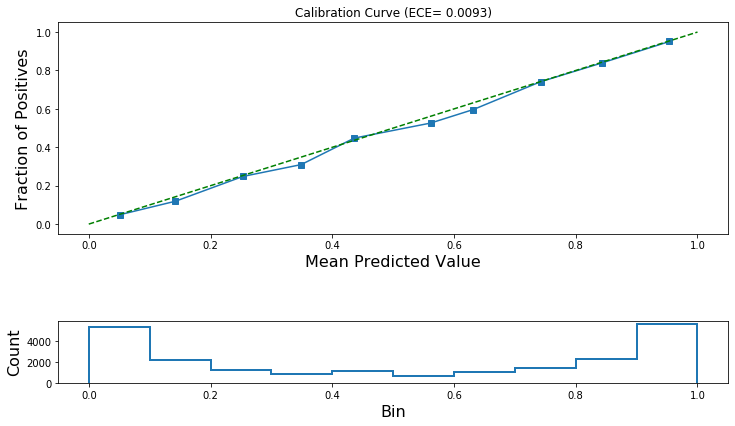

In [24]:
plot_reliability_diagram(
    calibration_data, lr_test_predictions, ece=[ece_post_calibration]
)

In [27]:
y_pred = np.zeros(len(test_predictions))
if use_platt:
    # the true predictions are the probabilistic outputs
    test_predictions = np.mean(np.array(all_test_probabilistic_predictions), axis=0)
y_pred[test_predictions.reshape(-1) > 0.5] = 1
print(
    "Accuracy of model before calibration: {:.4f}".format(
        accuracy_score(y_pred=y_pred, y_true=edge_labels_test)
    )
)
print(
    "Precision of model before calibration: {:.4f}".format(
        precision_score(y_pred=y_pred, y_true=edge_labels_test)
    )
)
print(
    "Recall of model before calibration: {:.4f}".format(
        recall_score(y_pred=y_pred, y_true=edge_labels_test)
    )
)
print(
    "F1-score of model before calibration: {:.4f}".format(
        f1_score(y_pred=y_pred, y_true=edge_labels_test)
    )
)

Accuracy of model before calibration: 0.7562
Precision of model before calibration: 0.6803
Recall of model before calibration: 0.9668
F1-score of model before calibration: 0.7986


In [28]:
y_pred = np.zeros(len(lr_test_predictions))
y_pred[lr_test_predictions[:, 0] > 0.5] = 1
print(
    "Accuracy for model after calibration: {:.4f}".format(
        accuracy_score(y_pred=y_pred, y_true=edge_labels_test)
    )
)
print(
    "Precision for model after calibration: {:.4f}".format(
        precision_score(y_pred=y_pred, y_true=edge_labels_test)
    )
)
print(
    "Recall for model after calibration: {:.4f}".format(
        recall_score(y_pred=y_pred, y_true=edge_labels_test)
    )
)
print(
    "F1-score for model after calibration: {:.4f}".format(
        f1_score(y_pred=y_pred, y_true=edge_labels_test)
    )
)

Accuracy for model after calibration: 0.8465
Precision for model after calibration: 0.8454
Recall for model after calibration: 0.8481
F1-score for model after calibration: 0.8468


# Community detection

In [5]:
G = nx.from_pandas_edgelist(graph_df, 'artist_name1', 'artist_name2')

print("The number of nodes in the graph is {}".format(len(list(G))))
print("The number of edges in the graph is {}".format(len(list(G.edges))))
print("The number of connected components in the graph is {}".format(nx.number_connected_components(G)))

The number of nodes in the graph is 39244
The number of edges in the graph is 73039
The number of connected components in the graph is 2180


In [6]:
Gcc = sorted([G.subgraph(c) for c in nx.connected_components(G)], key=len, reverse=True)
cc_sizes = []
for cc in list(Gcc):
    cc_sizes.append(len(cc.nodes()))
print(cc_sizes)

[33406, 70, 17, 15, 13, 13, 12, 12, 12, 12, 11, 11, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

In [27]:
# parameter specification
number_of_walks = 1
length = 2
batch_size = 64
epochs = 4
num_samples = [8, 8]
layer_sizes = [32, 32]
learning_rate = 1e-2

In [28]:
Gs = sg.StellarGraph.from_networkx(G, node_features=genre_df)

unsupervisedSamples = UnsupervisedSampler(Gs, nodes=G.nodes(), length=length, number_of_walks=number_of_walks)
generator = GraphSAGELinkGenerator(Gs, batch_size, num_samples)
train_gen = generator.flow(unsupervisedSamples)

assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2")

In [29]:
x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(output_dim=1, output_act="sigmoid", edge_embedding_method="ip")(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=learning_rate),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [32]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    shuffle=True,
)

Epoch 1/4
1227/1227 [==============================] - 351s 286ms/step - loss: 0.5210 - binary_accuracy: 0.7926
Epoch 2/4
1227/1227 [==============================] - 317s 259ms/step - loss: 0.5244 - binary_accuracy: 0.7884
Epoch 3/4
1227/1227 [==============================] - 309s 252ms/step - loss: 0.5244 - binary_accuracy: 0.7902
Epoch 4/4
1227/1227 [==============================] - 340s 277ms/step - loss: 0.5236 - binary_accuracy: 0.7897


In [35]:
node_ids = list(Gs.nodes())
node_gen = GraphSAGENodeGenerator(Gs, batch_size, num_samples).flow(node_ids)
embedding_model = keras.Model(inputs=x_inp[::2], outputs=x_out[0])
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)
print(node_embeddings.shape)

614/614 [==============================] - 33s 54ms/step
(39244, 32)


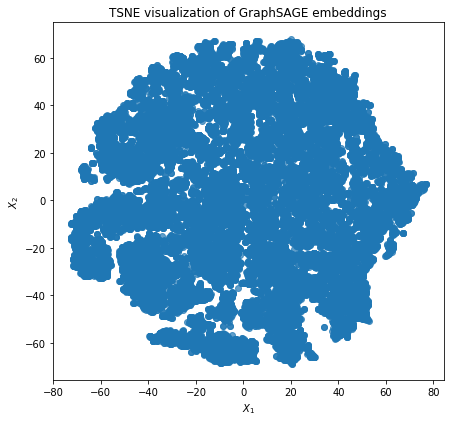

In [36]:
# TSNE visualisation to check whether the embeddings have some structure:
# CAUTION: VERY SLOW
if X.shape[1] > 2:
    trans = TSNE(n_components=2, random_state=42)
    emb_transformed = pd.DataFrame(trans.fit_transform(node_embeddings), index=node_ids)
else:
    emb_transformed = pd.DataFrame(node_embeddings, index=node_ids)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})

alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(emb_transformed[0], emb_transformed[1], alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("{} visualization of GraphSAGE embeddings".format(TSNE.__name__))
plt.show()